In [1]:
import autograd
import autograd.numpy as anp
from datetime import datetime
import lightgbm as lgb
from lightgbm.callback import early_stopping, log_evaluation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from scipy.signal import resample
import torch
import torch.nn.functional as F

from truth import IeeeGroundTruth
from wavelet import apply_wavelet
from peaks import get_peaks_v2
from signal_pross import (
    normalize_signal,
    detrend_w_poly,
    normalize_amplitude_to_1,
    n_moving_avg,
    min_max_scale,
    bandpass,
    get_hr
)

%matplotlib inline
plt.rcParams['figure.figsize'] = [18, 6]

In [2]:
truths = []
for subject in range(1, 8):

    truth = IeeeGroundTruth(subject, 1, directory = 'channel_data3')
    truth.align_rgb_bvp()
    truth.fill_nans()
    truth.process_rgb()
    truth.process_bvp()

    truths.append(truth)

In [3]:
def get_predicted_peaks(signal):
    return get_peaks_v2(signal, 64, 3.0, -1, prominence = 0.3, with_min_dist = True, with_valleys = False)
def get_true_peaks(signal):
    return get_peaks_v2(signal, 64, 3.0, -1, prominence = 0, with_min_dist = True, with_valleys = False)

def _process(targs, signal, smoothing_window = 10, use_bandpass = False):
    
    orig_len = len(signal)
    signal = n_moving_avg(signal, smoothing_window)
    signal = resample(signal, orig_len)
    if use_bandpass:
        signal = bandpass(signal, 64, [0.67, 3.0], 4)
    signal = min_max_scale(signal)
    
    targs = n_moving_avg(targs, 20)
    targs = resample(targs, orig_len)
    targs = min_max_scale(targs)
    
    return targs, signal

In [40]:
def LossFactory(n, split_size, loss_type = 'mse'):
    epsilon = 1e-8

    def mse_loss(y_pred, data):
        
        y_true = data.get_label()
        num_batches = int(n / split_size)
        errs = np.zeros_like(y_true)

        for i in range(num_batches):
            
            y_true_curr = y_true[i * split_size: (i + 1) * split_size]
            y_pred_curr = y_pred[i * split_size: (i + 1) * split_size]
            print(y_pred_curr[0: 10])
            err = y_true_curr - y_pred_curr
            errs[i * split_size: (i + 1) * split_size] = err

        grad = -2 * errs
        hess = 2 * np.ones_like(y_true)
        return grad, hess
    
    def dot_product_loss(y_pred, data):
        
        
        y_true = data.get_label()
        num_batches = int(n / split_size)
        grads = np.zeros_like(y_true)
        hesses = np.zeros_like(y_true)

        for i in range(num_batches):

            y_true_curr = y_true[i * split_size: (i + 1) * split_size]
            y_pred_curr = y_pred[i * split_size: (i + 1) * split_size]
            y_true_normalized = y_true_curr / (np.linalg.norm(y_true, axis=-1, keepdims=True) + epsilon)
            y_pred_normalized = y_pred_curr / (np.linalg.norm(y_pred, axis=-1, keepdims=True) + epsilon)
        
            dot_product = np.sum(y_true_normalized * y_pred_normalized, axis=-1)
            grad = -y_true_normalized + (y_pred_normalized * dot_product[..., np.newaxis])
            hess = np.eye(y_pred_curr.shape[-1])[np.newaxis, ...] * (1 - dot_product[..., np.newaxis, np.newaxis])
            hess = hess.squeeze().diagonal()

            grads[i * split_size: (i + 1) * split_size] = grad
            hesses[i * split_size: (i + 1) * split_size] = hess

        return grads, hesses
    
    if loss_type not in ['mse', 'dot']:
        raise ValueError(f'Loss type [{loss_type}] not supported')

    if loss_type == 'mse':
        return mse_loss
    elif loss_type == 'dot':
        return dot_product_loss

In [23]:
class MoodyGBM:
    
    def __init__(self, truths, label_col = 'bvp', subject_col = 'subject',
                model_type = 'gbdt', random_state = 0, loss_type = 'mse',
                augment = False, excluded_subject = None,
                # hyperparameters
                n_estimators = 100, split_size = 1280, learning_rate = 0.1, test_size = 0.3):
        
        if model_type not in ['gbdt', 'rf']:
            raise ValueError(f'Model type [{model_type}] not supported')
        
        self.label_col = label_col
        self.subject_col = subject_col
        self.split_size = split_size
        self.learning_rate = learning_rate
        self.test_size = test_size
        self.random_state = random_state,
        self.n_estimators = n_estimators
        self.gbm = None
        self.training_loss = None

        self.given_data = self.prepare_dataset_from_subjects(truths)
        self.excluded_subject = excluded_subject
        if self.excluded_subject is not None:
            self.given_data = self.given_data[self.given_data[self.subject_col] != self.excluded_subject]

        # random.seed(self.random_state)
        splits = self.split_data()
        self.train_split_indices = random.sample(range(len(splits)), int(len(splits) * (1 - self.test_size)))
        
        self.train_splits = [splits[i] for i in self.train_split_indices]
        self.test_splits = [splits[i] for i in range(len(splits)) if i not in self.train_split_indices]
        
        train_indices = [idx for split in self.train_splits for idx in split]
        self.train_data = self.given_data.iloc[train_indices].drop(columns = [self.subject_col])
        self.train_X = self.train_data.drop(columns = [self.label_col]).to_numpy()
        self.train_y = self.train_data[self.label_col].to_numpy()

        test_indices = [idx for split in self.test_splits for idx in split]
        self.test_data = self.given_data.iloc[test_indices].drop(columns = [self.subject_col])
        self.test_X = self.test_data.drop(columns = [self.label_col]).to_numpy()
        self.test_y = self.test_data[self.label_col].to_numpy()

        if augment:
            self.augment_data()

        self.train_data = lgb.Dataset(self.train_X, self.train_y)
        self.test_data = lgb.Dataset(self.test_X, self.test_y)

        self.loss = LossFactory(len(self.train_X), self.split_size, loss_type)
    
    def split_data(self, to_exclude = None):
        
        data_in_use = self.given_data if to_exclude is None else self.given_data[~self.given_data[self.subject_col].isin(to_exclude)]

        subject_indices = data_in_use.groupby(self.subject_col).indices
        splits = []
        for _, indices in subject_indices.items():
            
            n_splits = len(indices) // self.split_size
            if n_splits > 0:

                subject_splits = []
                for i in range(n_splits):
                    split_start = i * self.split_size
                    split_end = (i + 1) * self.split_size
                    subject_split = indices[split_start: split_end]
                    subject_splits.append(subject_split)
                
                splits.extend(subject_splits)
        
        return splits
    
    def augment_data(self):
        pass

    def fit(self):
        
        t1 = datetime.today()
        params = {
            'metric': 'None',
            'verbosity': -1,
            # 'seed': self.random_state,
            'learning_rate': self.learning_rate,
            'objective': 'regression'
        }
        
        training_meta = {}
        self.gbm = lgb.train(
            params,
            self.train_data,
            valid_sets = [self.train_data],
            fobj = self.loss,
            num_boost_round = self.n_estimators,
            feval=self.hr_error_eval_metric,
            callbacks=[
                early_stopping(stopping_rounds=50),
                log_evaluation(period=1)
            ],
            evals_result = training_meta
        )

        self.training_loss = training_meta['training']['hr_err']
        print(f'Finished training in {datetime.today() - t1}')

    def predict(self, X):
        return self.gbm.predict(X)

    def eval(self):
        
        errs = []
        nsplits = int(len(self.test_X) / self.split_size)
        mses = np.ones_like(self.test_y)
        for i in range(nsplits):

            curr_pred = self.predict(self.test_X[i * self.split_size: (i + 1) * self.split_size, :])
            curr_true = self.test_y[i * self.split_size: (i + 1) * self.split_size]
            curr_true, curr_pred = _process(curr_true, curr_pred, smoothing_window=5, use_bandpass=True)
            mses[i * self.split_size: (i + 1) * self.split_size] = curr_true - curr_pred

            hr_err = self.get_hr_error(curr_true, curr_pred, square = False)
            errs.append(hr_err)
        
        return np.mean(np.square(mses)), np.mean(errs), np.mean(np.square(errs))

    def plot_loss(self):
        if self.training_loss is not None:
            plt.plot(self.training_loss)
            plt.title('Training Loss')
    
    @staticmethod
    def prepare_dataset_from_subjects(truths, data_beg = 111, data_end = 15000):
        data_arr = []
        for i in range(len(truths)):    
            truth = truths[i]
            data = truth.prepare_data_for_ml()
            data = data.iloc[data_beg: data_end, :]
            data['subject'] = i + 1
            data_arr.append(data)
        return pd.concat(data_arr)
    
    def hr_error_eval_metric(self, y_pred, eval_data):
        y_true = eval_data.get_label()
        nsplits = int(len(y_pred) / self.split_size)
        hr_err = 0
        for i in range(nsplits):
            curr_pred = y_pred[i * self.split_size: (i + 1) * self.split_size]
            curr_true = y_true[i * self.split_size: (i + 1) * self.split_size]
            curr_true, curr_pred = _process(curr_true, curr_pred)
            hr_err += self.get_hr_error(curr_true, curr_pred, square = True)
        return 'hr_err', hr_err, False
    
    @staticmethod
    def get_hr_error(y_true, y_pred, square = True):

        true_peaks, _ = get_true_peaks(y_true)
        pred_peaks, _ = get_predicted_peaks(y_pred)

        true_ibis = np.diff(true_peaks) / 64
        true_hr = 60 / np.mean(true_ibis)

        if len(pred_peaks) >= 2:
            pred_ibis = np.diff(pred_peaks) / 64
            pred_hr = 60 / np.mean(pred_ibis)
        else:
            pred_hr = 0
        
        if square:
            return np.power(true_hr - pred_hr, 2)
        return abs(true_hr - pred_hr)


[1]	training's hr_err: 137476
Training until validation scores don't improve for 50 rounds
[2]	training's hr_err: 109221
[3]	training's hr_err: 115933
[4]	training's hr_err: 122994
[5]	training's hr_err: 130291
[6]	training's hr_err: 129774
[7]	training's hr_err: 131885
[8]	training's hr_err: 131837
[9]	training's hr_err: 131287
[10]	training's hr_err: 130168
[11]	training's hr_err: 132508
[12]	training's hr_err: 133721
[13]	training's hr_err: 133299
[14]	training's hr_err: 133558
[15]	training's hr_err: 134963
[16]	training's hr_err: 136663
[17]	training's hr_err: 137604
[18]	training's hr_err: 137010
[19]	training's hr_err: 136382
[20]	training's hr_err: 136444
[21]	training's hr_err: 137542
[22]	training's hr_err: 136139
[23]	training's hr_err: 136848
[24]	training's hr_err: 136865
[25]	training's hr_err: 137342
[26]	training's hr_err: 136508
[27]	training's hr_err: 135638
[28]	training's hr_err: 135724
[29]	training's hr_err: 136632
[30]	training's hr_err: 137187
[31]	training's hr

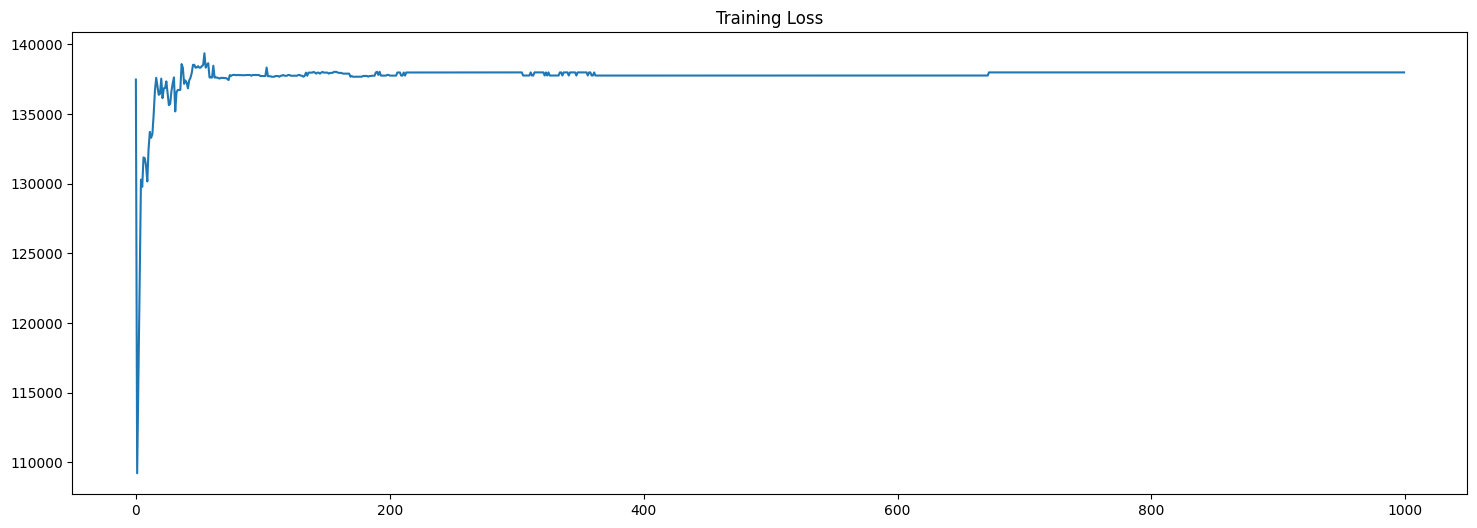

In [46]:
test_subject = 7
test_subject_truth = truths[test_subject - 1]

mod = MoodyGBM(truths, n_estimators = 1000, loss_type = 'dot', split_size = 1280, excluded_subject = test_subject, model_type = 'gbdt')
mod.fit()
mse, hr_err, hr_err_sq = mod.eval()

print(f'MSE: {mse}')
print(f'HR error: {hr_err}')
print(f'HR error squared: {hr_err_sq}')

mod.plot_loss()

True HR: 48.813559322033896; Pred HR: 89.30232558139535


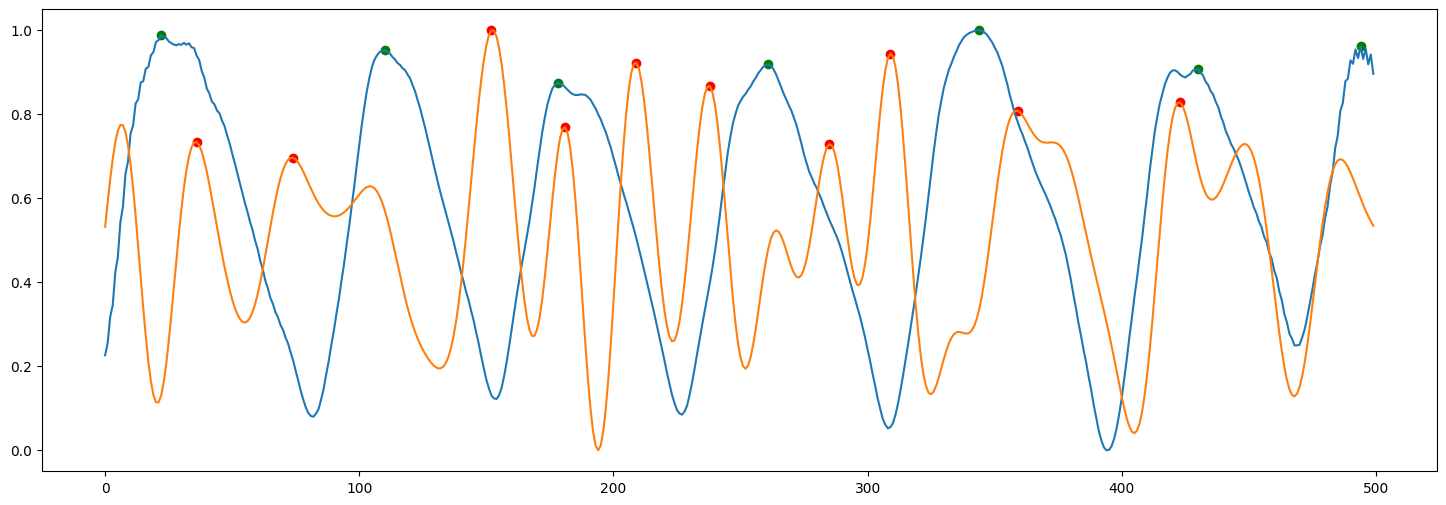

In [47]:
beg = 3000
end = 3500

model = mod

data = test_subject_truth.prepare_data_for_ml()
x = data.drop(columns = ['bvp']).to_numpy()
y = data['bvp'].to_numpy()

targ = y[beg: end]
pred = model.predict(x)[beg: end]
targ, pred = _process(targ, pred)
pred = bandpass(pred, 64, [0.67, 3.0], 4)
pred = min_max_scale(pred)

pred_peaks, _ = get_predicted_peaks(pred)
true_peaks, _ = get_true_peaks(targ)

plt.plot(targ)
plt.plot(pred)
plt.scatter(pred_peaks, pred[pred_peaks], c='r')
plt.scatter(true_peaks, targ[true_peaks], c='g')

pred_ibis = np.diff(pred_peaks) / 64
true_ibis = np.diff(true_peaks) / 64
pred_hr = get_hr(pred_ibis)
true_hr = get_hr(true_ibis)
print(f'True HR: {true_hr}; Pred HR: {pred_hr}')

In [8]:
def custom_dot_product_loss(y_true, y_pred, split_size):

    num_batches = int(len(y_true) / split_size)
    grads = np.zeros_like(y_true)
    hesses = np.zeros_like(y_true)
    print(num_batches)
    for i in range(num_batches):

        y_true_curr = y_true[i * split_size: (i + 1) * split_size]
        y_pred_curr = y_pred[i * split_size: (i + 1) * split_size]
        y_true_normalized = y_true_curr / np.linalg.norm(y_true, axis=-1, keepdims=True)
        y_pred_normalized = y_pred_curr / np.linalg.norm(y_pred, axis=-1, keepdims=True)
    
        dot_product = np.sum(y_true_normalized * y_pred_normalized, axis=-1)
        print(dot_product)
        grad = -y_true_normalized + (y_pred_normalized * dot_product[..., np.newaxis])
        hess = np.eye(y_pred_curr.shape[-1])[np.newaxis, ...] * (1 - dot_product[..., np.newaxis, np.newaxis])
        hess = hess.squeeze().diagonal()

        grads[i * split_size: (i + 1) * split_size] = grad
        hesses[i * split_size: (i + 1) * split_size] = hess


    return grads, hesses

g, h = custom_dot_product_loss(targ, pred, 250)
h.shape


2
0.4491059559922578
0.4543033026623664


(500,)